# Brandelyn Florida Portion



## Load Libraries and Data

In [8]:
gcs_path = 'gs://pstat135-voter-file/VM2Uniform'
numrows = dict()
print("%s: " % ('VM2Uniform--FL--2021-05-19'), end="")
    
# read dataframe for one_state
df_fl = spark.read.parquet("/".join([gcs_path, 'VM2Uniform--FL--2021-05-19']))
numrows['VM2Uniform--FL--2021-05-19'] = df_fl.count()
    
print("%d" % (numrows['VM2Uniform--FL--2021-05-19']))

VM2Uniform--FL--2021-05-19: 

14168189


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
from pyspark.ml.feature import RFormula

## Research Questions

- How does socioeconomic background (education, income, religion, etc ) affect voter turnout?
    - How does property (household, land) ownership affect voter turnouts or patterns?
    - How does education level relate to voter alignment or patterns?
    - How would age and gender relate to voter alignment or patterns?
    
Let's consider the two most recent Presidential Elections to answer our question. The main candidates in 2016 were Trump and Clinton, and in 2020 were Trump and Biden. One interesting thing of note is that Clinton was the first women to represent a major party in the presidential election.

In [10]:
# first pull out columns of interest
interest_cols = ["General_2020",
                 "CommercialData_Education",
                 "Voters_Age", "Voters_Gender",
                 "Residence_Addresses_Property_LandSq_Footage",
                 "Parties_Description", 
                 "CommercialData_EstimatedHHIncomeAmount"                           
]

In [47]:
df_sub=df_fl.select("General_2020",
                 "CommercialData_Education",
                 "Voters_Age", "Voters_Gender",
                 "Residence_Addresses_Property_LandSq_Footage",
                 "Parties_Description", 
                 "CommercialData_EstimatedHHIncomeAmount")
df_sub.printSchema()

root
 |-- General_2020: string (nullable = true)
 |-- CommercialData_Education: string (nullable = true)
 |-- Voters_Age: string (nullable = true)
 |-- Voters_Gender: string (nullable = true)
 |-- Residence_Addresses_Property_LandSq_Footage: string (nullable = true)
 |-- Parties_Description: string (nullable = true)
 |-- CommercialData_EstimatedHHIncomeAmount: string (nullable = true)



## Sample

For visualization of the data, we will need to take a sample of the data to be able to process these plots. Summaries will be done with the entire dataset to ensure the plots are what is intended.


In [11]:
# randomly take a sample of the data frame and convert to pandas
df_fl_pd = df_fl.select(*interest_cols).sample(True, 0.01, 123).toPandas()

In [12]:
# now take a 2000 subset of the pandaDF
df_fl_pd = df_fl_pd.sample(10000, random_state=123)

df_fl_pd["State"] = "FL"

df_fl_pd.head()

,General_2020,CommercialData_Education,Voters_Age,Voters_Gender,Residence_Addresses_Property_LandSq_Footage,Parties_Description,CommercialData_EstimatedHHIncomeAmount,State
138895,None,None,62,F,None,Non-Partisan,$30220,FL
82444,Y,None,54,M,0043000,Democratic,$53299,FL
61288,Y,Grad Degree - Extremely Likely,43,F,None,Democratic,$72000,FL
137977,Y,None,55,F,0013000,Registered Independent,$69916,FL
41335,Y,None,65,M,0014000,Republican,$87318,FL


## Age and Gender

In [12]:
ageFL = df_fl.select("Voters_Age",'Parties_Description')
ageFL.groupBy('Parties_Description').agg(F.mean('Voters_Age'), F.count('Voters_Age').alias('Voters_in_Party')).show(10)

+--------------------+------------------+---------------+
| Parties_Description|   avg(Voters_Age)|Voters_in_Party|
+--------------------+------------------+---------------+
|          Republican| 55.78978141797492|        4994235|
|Registered Indepe...| 45.94540307883206|         180523|
|               Other| 39.66997026759167|           1009|
|         Libertarian|40.406567493665804|          39863|
|               Green|39.804321404456445|           7405|
|              Reform| 50.80409556313993|           1465|
|      Constitutional|47.140307907627715|           2858|
|          Democratic|51.874933047463514|        5186510|
|           Socialist| 31.86215334420881|           1226|
|        Non-Partisan| 47.31178927220779|        3741851|
+--------------------+------------------+---------------+



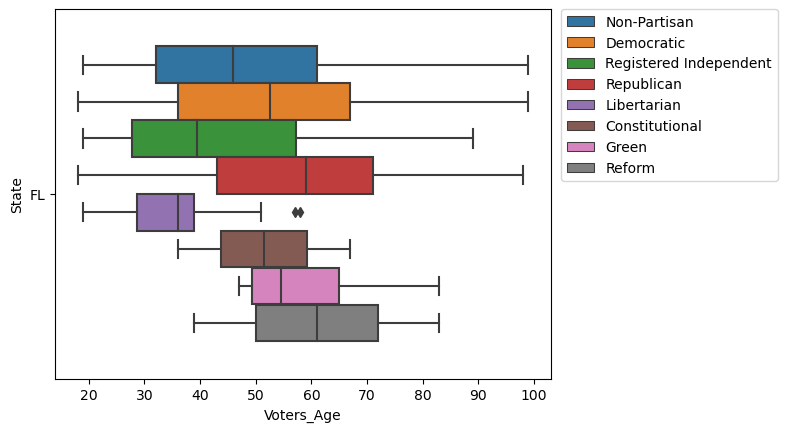

In [7]:
df_fl_pd['Voters_Age']=pd.to_numeric(df_fl_pd['Voters_Age'])

ageplot_fl = sns.boxplot(data=df_fl_pd, x="Voters_Age", y="State",hue="Parties_Description")
ageplot_fl = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ageplot_fl

In [8]:
genFL = df_fl.select("Voters_Gender")
genFL.groupBy('Voters_Gender').count().show()

+-------------+-------+
|Voters_Gender|  count|
+-------------+-------+
|            F|7564301|
|         null|  12131|
|            M|6591757|
+-------------+-------+



In [28]:
genFL2 = df_fl.select('Voters_Gender','Parties_Description')

female_party_FL = genFL2.where(genFL2.Voters_Gender == "F")\
    .groupBy('Parties_Description')\
    .count() \
    .sort(F.desc('count'))

male_party_FL = genFL2.where(genFL2.Voters_Gender == "M")\
    .groupBy('Parties_Description')\
    .count() \
    .sort(F.desc('count'))   

female_party_FL.show()
male_party_FL.show()

+--------------------+-------+
| Parties_Description|  count|
+--------------------+-------+
|          Democratic|3078257|
|          Republican|2500907|
|        Non-Partisan|1871183|
|Registered Indepe...|  95044|
|         Libertarian|  12851|
|               Green|   3537|
|      Constitutional|    871|
|              Reform|    620|
|               Other|    522|
|           Socialist|    509|
+--------------------+-------+



+--------------------+-------+
| Parties_Description|  count|
+--------------------+-------+
|          Republican|2496035|
|          Democratic|2109374|
|        Non-Partisan|1865990|
|Registered Indepe...|  85454|
|         Libertarian|  27003|
|               Green|   3865|
|      Constitutional|   1988|
|              Reform|    845|
|           Socialist|    717|
|               Other|    486|
+--------------------+-------+



The democratic party with the most total votes in Florida is the Republican party, and both genders have around 2,500,000 votes.

## Income

In [54]:
# remove the dollar sign
df_sub = df_sub.withColumn('CommercialData_EstimatedHHIncomeAmount', F.regexp_replace('CommercialData_EstimatedHHIncomeAmount', '[$,]', '').cast('double'))
df_sub.printSchema
df_sub.show(1)

+------------+------------------------+----------+-------------+-------------------------------------------+-------------------+--------------------------------------+
|General_2020|CommercialData_Education|Voters_Age|Voters_Gender|Residence_Addresses_Property_LandSq_Footage|Parties_Description|CommercialData_EstimatedHHIncomeAmount|
+------------+------------------------+----------+-------------+-------------------------------------------+-------------------+--------------------------------------+
|           Y|                    null|        63|            F|                                       null|         Democratic|                               77000.0|
+------------+------------------------+----------+-------------+-------------------------------------------+-------------------+--------------------------------------+
only showing top 1 row



In [31]:
incomeFL = df_sub.select("CommercialData_EstimatedHHIncomeAmount",'Parties_Description')
incomeFL.groupBy('Parties_Description').agg(F.mean('CommercialData_EstimatedHHIncomeAmount')).show()

+--------------------+-------------------------------------------+
| Parties_Description|avg(CommercialData_EstimatedHHIncomeAmount)|
+--------------------+-------------------------------------------+
|          Republican|                          95848.90398604021|
|Registered Indepe...|                          90602.33884166203|
|               Other|                          78497.70528455285|
|         Libertarian|                          91059.33661609668|
|               Green|                          82380.67223382046|
|              Reform|                          83547.96648044692|
|      Constitutional|                           81675.6080546566|
|          Democratic|                           80272.5717996799|
|           Socialist|                          80178.43254637437|
|        Non-Partisan|                          87271.92492421155|
+--------------------+-------------------------------------------+



In [ ]:
# income
income_chart_fl = sns.countplot(data=df_fl_pd, x="State",
                             hue="CommercialData_EstimatedHHIncomeAmount").set(title="Income")
income_chart_fl

[Text(0.5, 1.0, 'Income')]

## Land Ownership

In [10]:
landFL = df_fl.select('Residence_Addresses_Property_LandSq_Footage','Parties_Description')
landFL.groupBy('Parties_Description').agg(F.mean('Residence_Addresses_Property_LandSq_Footage'), F.count('Residence_Addresses_Property_LandSq_Footage').alias('Land_in_Party')).show()

+--------------------+------------------------------------------------+-------------+
| Parties_Description|avg(Residence_Addresses_Property_LandSq_Footage)|Land_in_Party|
+--------------------+------------------------------------------------+-------------+
|          Republican|                              54866.257821564395|      4069838|
|Registered Indepe...|                              37672.557360727704|       132582|
|               Other|                               57884.89208633093|          695|
|         Libertarian|                               44410.34913538037|        30418|
|               Green|                               41537.50694573069|         5399|
|              Reform|                               44803.71352785146|         1131|
|      Constitutional|                               49172.27084292952|         2171|
|          Democratic|                              38423.196508220586|      3890051|
|           Socialist|                               4

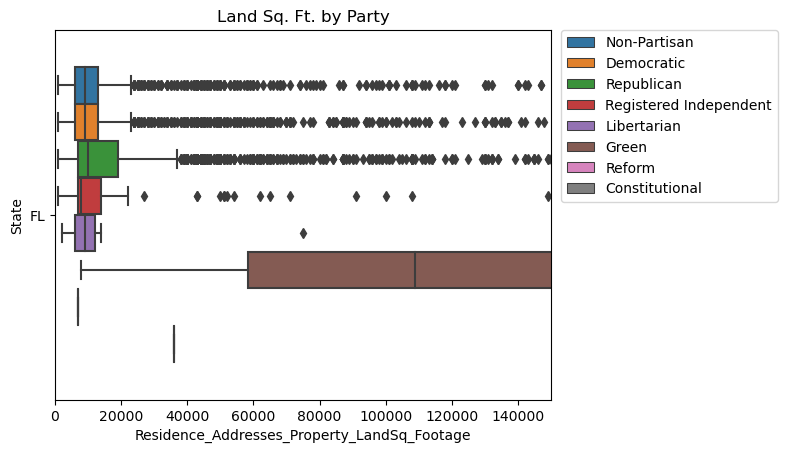

In [31]:
df_fl_pd['Residence_Addresses_Property_LandSq_Footage']=pd.to_numeric(df_fl_pd['Residence_Addresses_Property_LandSq_Footage'])

land_plot_fl = sns.boxplot(data=df_fl_pd, x="Residence_Addresses_Property_LandSq_Footage", y="State", hue="Parties_Description")
land_plot_fl.set(title="Land Sq. Ft. by Party")
land_plot_fl.set_xlim(0, 150000)
land_plot_fl = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

land_plot_fl

In [34]:
sqftFL = df_fl.select('Residence_Addresses_Property_HomeSq_Footage','Parties_Description')
sqftFL.groupBy('Parties_Description').agg(F.mean('Residence_Addresses_Property_HomeSq_Footage')).show()

+--------------------+------------------------------------------------+
| Parties_Description|avg(Residence_Addresses_Property_HomeSq_Footage)|
+--------------------+------------------------------------------------+
|          Republican|                                2450.96018730805|
|Registered Indepe...|                              2261.1233339590763|
|               Other|                                          2003.0|
|         Libertarian|                               2296.959868959869|
|               Green|                               2052.957233848954|
|              Reform|                               2208.275261324042|
|      Constitutional|                               2105.243619489559|
|          Democratic|                                2110.28670790332|
|           Socialist|                               2098.076923076923|
|        Non-Partisan|                              2223.7841983259996|
+--------------------+------------------------------------------

## Education


In [39]:
df_sub.select('CommercialData_Education').distinct().show() # quick glance at the possible catergories

+------------------------+
|CommercialData_Education|
+------------------------+
|    Grad Degree - Ext...|
|    Grad Degree - Likely|
|    Bach Degree - Ext...|
|     HS Diploma - Likely|
|                    null|
|    Less than HS Dipl...|
|    Some College - Li...|
|    Vocational Techni...|
|    Some College -Ext...|
|    HS Diploma - Extr...|
|    Bach Degree - Likely|
|    Less than HS Dipl...|
+------------------------+



In [9]:
eduFL = df_fl.select('CommercialData_AreaMedianEducationYears','Parties_Description')
eduFL.groupBy('Parties_Description').agg(F.mean('CommercialData_AreaMedianEducationYears'), F.count('CommercialData_AreaMedianEducationYears').alias('Educated_in_Party')).show()

+--------------------+--------------------------------------------+-----------------+
| Parties_Description|avg(CommercialData_AreaMedianEducationYears)|Educated_in_Party|
+--------------------+--------------------------------------------+-----------------+
|          Republican|                          12.721128189950365|          4851878|
|Registered Indepe...|                          12.715225585379782|           175100|
|               Other|                           12.57711950970378|              979|
|         Libertarian|                          12.708358154834364|            38609|
|               Green|                          12.611017661900757|             7134|
|              Reform|                          12.569808646350106|             1411|
|      Constitutional|                          12.474791439970984|             2757|
|          Democratic|                          12.569242029544087|          5036067|
|           Socialist|                           12.58

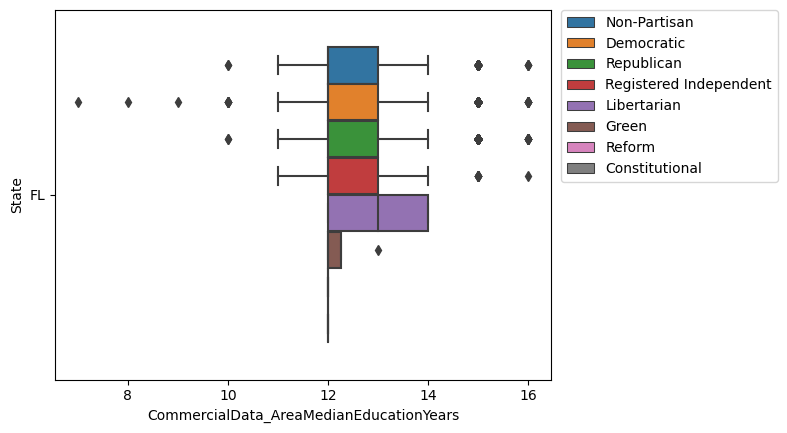

In [35]:
# education
df_fl_pd['CommercialData_AreaMedianEducationYears']=pd.to_numeric(df_fl_pd['CommercialData_AreaMedianEducationYears'])

eduplot_fl = sns.boxplot(data=df_fl_pd, x="CommercialData_AreaMedianEducationYears", y="State", hue="Parties_Description")
eduplot_fl = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
eduplot_fl
# there isnt much difference here in the median years of education, and is about expected
# the outliers here make sense too, that highly educated people would likely be aligned with the main parties
# or this may be due to a greater amt of people in the main parties regardless of education

In [14]:
partyFL = df_fl.select('Parties_Description')
partyFL.groupBy('Parties_Description').count().show()

+--------------------+-------+
| Parties_Description|  count|
+--------------------+-------+
|          Republican|4998555|
|Registered Indepe...| 180545|
|               Other|   1009|
|         Libertarian|  39863|
|               Green|   7406|
|              Reform|   1465|
|      Constitutional|   2859|
|          Democratic|5191785|
|           Socialist|   1226|
|        Non-Partisan|3743476|
+--------------------+-------+



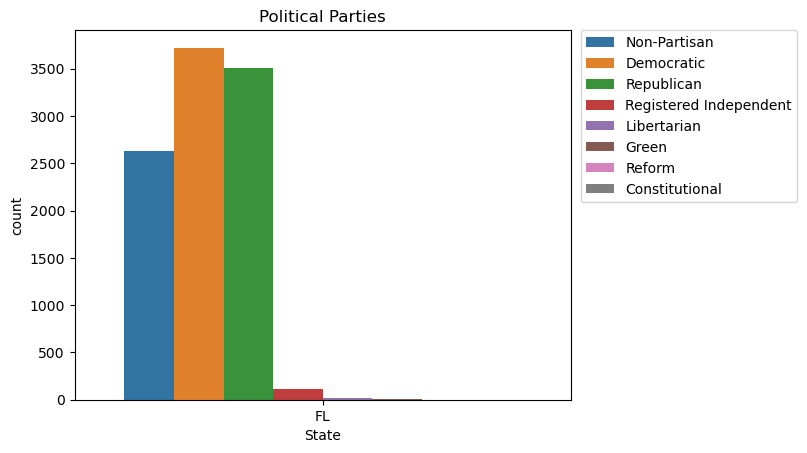

In [36]:
party_chart_fl = sns.countplot(data=df_fl_pd, x="State",
                             hue="Parties_Description").set(title="Political Parties")
party_chart_fl = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

party_chart_fl

## Modeling Preperation
Some adjustments to the dataset to prepare it for modeling.

In [55]:
df_sub.show(3) # quick look
df_sub.printSchema()

+------------+------------------------+----------+-------------+-------------------------------------------+-------------------+--------------------------------------+
|General_2020|CommercialData_Education|Voters_Age|Voters_Gender|Residence_Addresses_Property_LandSq_Footage|Parties_Description|CommercialData_EstimatedHHIncomeAmount|
+------------+------------------------+----------+-------------+-------------------------------------------+-------------------+--------------------------------------+
|           Y|                    null|        63|            F|                                       null|         Democratic|                               77000.0|
|           N|    Some College - Li...|        33|            M|                                       null|         Democratic|                               77000.0|
|           N|                    null|        27|            F|                                       null|         Democratic|                                

In [73]:
# remove the dollar sign
df_sub = df_sub.withColumn('CommercialData_EstimatedHHIncomeAmount', F.regexp_replace('CommercialData_EstimatedHHIncomeAmount', '[$,]', '').cast('double'))
df_sub.printSchema

# cast Age to integer
df_sub = df_sub.withColumn("Voters_Age", df_sub.Voters_Age.cast('integer')) 

# cast land sqft to double
df_sub = df_sub.withColumn("Residence_Addresses_Property_LandSq_Footage", df_sub.Voters_Age.cast('double')) 

# the nulls in General_2020 are noshows, but we want to replace them with 'N' rather than null
df_sub = df_sub.fillna('N', subset='General_2020')
df_sub.show(1)

df_sub.printSchema()

+------------+------------------------+----------+-------------+-------------------------------------------+-------------------+--------------------------------------+
|General_2020|CommercialData_Education|Voters_Age|Voters_Gender|Residence_Addresses_Property_LandSq_Footage|Parties_Description|CommercialData_EstimatedHHIncomeAmount|
+------------+------------------------+----------+-------------+-------------------------------------------+-------------------+--------------------------------------+
|           Y|                    null|        63|            F|                                       63.0|         Democratic|                               77000.0|
+------------+------------------------+----------+-------------+-------------------------------------------+-------------------+--------------------------------------+
only showing top 1 row

root
 |-- General_2020: string (nullable = false)
 |-- CommercialData_Education: string (nullable = true)
 |-- Voters_Age: integer (null

In [74]:
df_sub.count()

14168189

In [36]:
[(c, df_sub.where(F.col(c).isNull()).count()) for c in df_sub.columns]

[('General_2020', 3333771),
 ('CommercialData_Education', 5922809),
 ('Voters_Age', 11244),
 ('Voters_Gender', 12131),
 ('Residence_Addresses_Property_LandSq_Footage', 3212851),
 ('Parties_Description', 0),
 ('CommercialData_EstimatedHHIncomeAmount', 316202)]

In [75]:
df_sub_no_null = df_sub.dropna()
df_sub_no_null.count()

8206899

## Modeling

In [84]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import RFormula
import numpy as np

In [58]:
# RFormula will automatically feature engineer
supervised = RFormula(formula="General_2020 ~ .") # use . to select all columns

In [ ]:
# Fit RFormula Transformer
preparedDF = supervised.fit(df_sub_no_null).transform(df_sub_no_null)

In [ ]:
# quick look
preparedDF.show(5,truncate=False)

+------------+------------------------------+----------+-------------+-------------------------------------------+-------------------+--------------------------------------+-------------------------------------------------------+-----+
|General_2020|CommercialData_Education      |Voters_Age|Voters_Gender|Residence_Addresses_Property_LandSq_Footage|Parties_Description|CommercialData_EstimatedHHIncomeAmount|features                                               |label|
+------------+------------------------------+----------+-------------+-------------------------------------------+-------------------+--------------------------------------+-------------------------------------------------------+-----+
|N           |Some College - Likely         |33        |M            |33.0                                       |Democratic         |77000.0                               |(23,[0,10,12,14,22],[1.0,33.0,33.0,1.0,77000.0])       |1.0  |
|Y           |HS Diploma - Likely           |55        |

In [79]:
# names of columns used to make feature vector, and then stored in pandaDF
featureCols = pd.DataFrame(preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
  preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

featureCols = featureCols.set_index('idx')

,name
idx,
0,CommercialData_Education_Some College - Likely
1,CommercialData_Education_Bach Degree - Extreme...
2,CommercialData_Education_HS Diploma - Extremel...
3,CommercialData_Education_HS Diploma - Likely
4,CommercialData_Education_Bach Degree - Likely


In [80]:
# split the data
train, test = preparedDF.randomSplit([0.7, 0.3],seed=123)

In [81]:
# LogisticRegression
lr = LogisticRegression(labelCol="label",featuresCol="features")

In [82]:
lrModel = lr.fit(train) # train model

23/03/17 06:13:16 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/03/17 06:13:16 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [85]:
coefsArray = np.abs(np.array(lrModel.coefficients))  # convert to np.array
coefsDF = pd.DataFrame(coefsArray, columns=['coefs'])  # to pandas

coefsDF = coefsDF.merge(featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
coefsDF.sort_values('coefs', inplace=True)  # Sort them
coefsDF.head()

,coefs,name
22,0.000005,CommercialData_EstimatedHHIncomeAmount
12,0.013801,Residence_Addresses_Property_LandSq_Footage
10,0.013801,Voters_Age
18,0.013825,Parties_Description_Green
15,0.070276,Parties_Description_Non-Partisan


In [86]:
plt.rcParams["figure.figsize"] = (20,3)

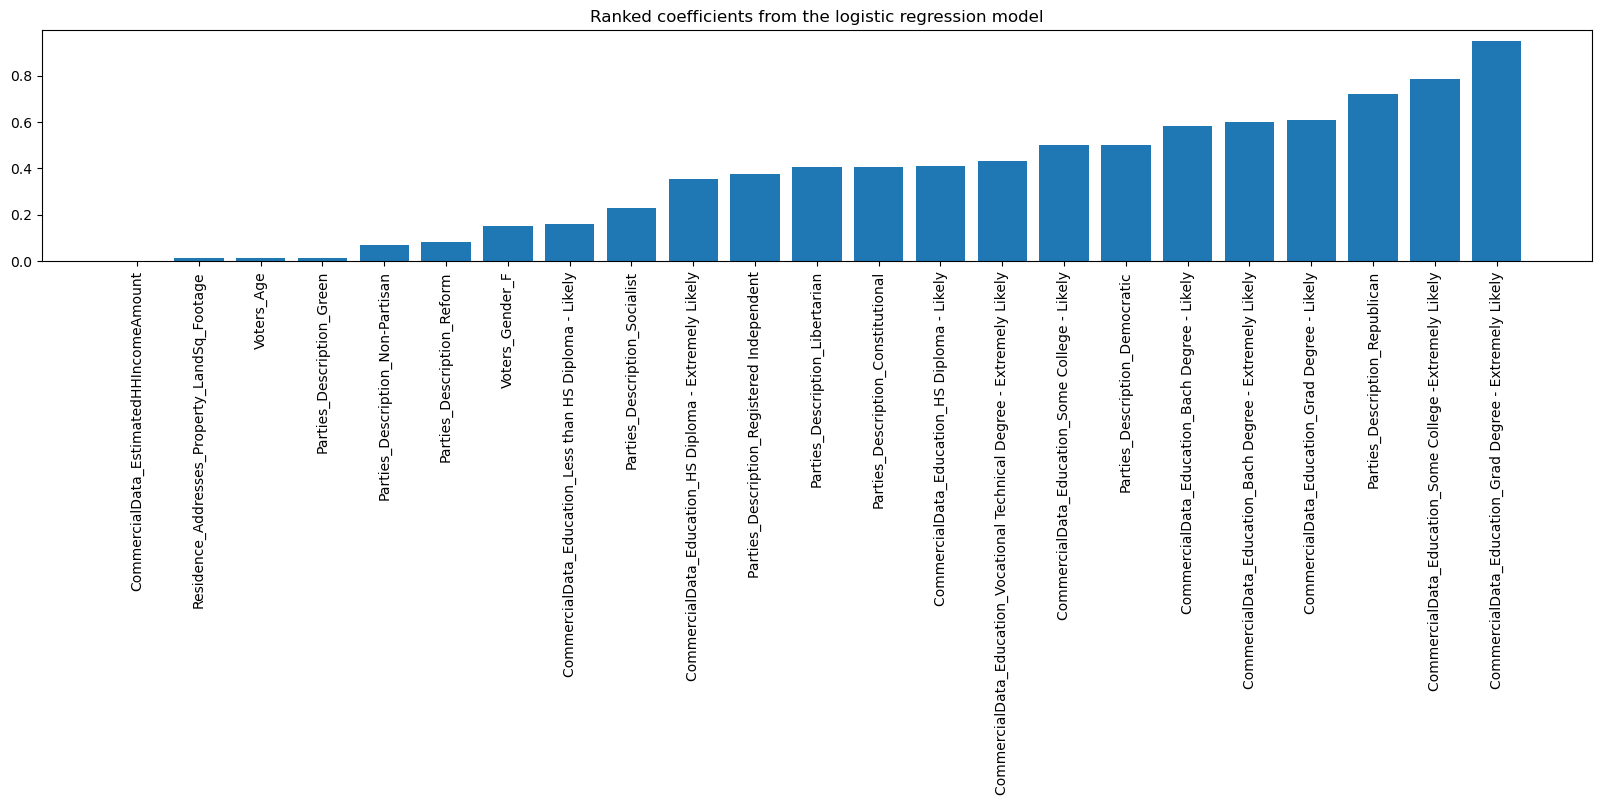

In [87]:
plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF.coefs)
plt.title('Ranked coefficients from the logistic regression model')
plt.show()

## Model Evaluation

In [88]:
summary = lrModel.summary
print("AUC:", summary.areaUnderROC)

AUC: 0.6941832940009203


In [92]:
# fit model on test
fittedTest = lrModel.transform(test)

In [93]:
fittedTest.select("label","prediction","rawPrediction").show(5)

+-----+----------+--------------------+
|label|prediction|       rawPrediction|
+-----+----------+--------------------+
|  1.0|       0.0|[0.92092329844351...|
|  1.0|       1.0|[-0.0518948961667...|
|  1.0|       0.0|[0.12011116562862...|
|  1.0|       0.0|[1.00417459021075...|
|  1.0|       0.0|[0.97034125740654...|
+-----+----------+--------------------+
only showing top 5 rows



In [94]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

aucEvaluator = BinaryClassificationEvaluator()\
.setMetricName("areaUnderROC")\
.setRawPredictionCol("prediction")\
.setLabelCol("label")

In [95]:
# AUC on test set
AUC = aucEvaluator.evaluate(fittedTest)
print("Test AUC:",AUC)
#AUC on training
print("Training AUC:", summary.areaUnderROC)

Test AUC: 0.5049301726815407
Training AUC: 0.6941832940009203
